In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial import distance_matrix
import itertools

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
from data.construct import load_data_from_configuration
import configuration

In [2]:
import gust

In [3]:
dataset_name = 'pubmed'
dataset = gust.datasets.load_dataset(dataset_name)

In [4]:
graph = dataset.standardize(
        make_unweighted = True, make_undirected = True,
        no_self_loops = True, select_lcc = True
    )

In [5]:
graph

<Undirected, unweighted and connected SparseGraph with 88648 edges (no self-loops). Data: adj_matrix (19717x19717), attr_matrix (19717x500), labels (19717)>

In [6]:


    
if dataset_name == 'cora_ml':
    class_names = np.array([cn.split('/')[-1] for cn in graph.class_names])
else:
    class_names = graph.class_names
if class_names is None:
    class_names = np.array([f'{label}' for label in range(graph.labels.max() + 1)])
#g = sns.JointGrid(data=num_intra_cluster_edges)

In [7]:
# Count intra-cluster edges
num_intra_cluster_edges = np.zeros((len(np.unique(graph.labels)), len(np.unique(graph.labels))), dtype=int)
for label_i in range(len(class_names)):
    for label_j in range(len(class_names)):
        num_intra_cluster_edges[label_i, label_j] = graph.adj_matrix[graph.labels == label_i][:, graph.labels == label_j].nnz


<AxesSubplot:>

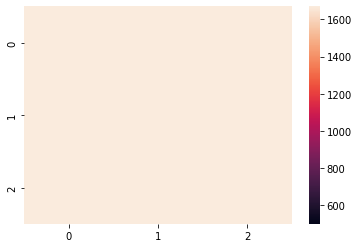

In [8]:

sns.heatmap(pd.DataFrame(num_intra_cluster_edges, class_names, class_names), vmax=500)

In [9]:
# Get all partitions of labels into two sets (2^(num_lables - 1) - 1, as we exclude empty partions)
partitions = [mask for mask in [np.array([False] + list(m)) for m in itertools.product([True, False], repeat=len(class_names) - 1)] if mask.sum() > 0]

In [10]:
# Calculate the edge density within a partition and between partitions
partition_inter_densities = []
for mask in partitions:
    # Treat the two partitions as classes
    edges_inter = num_intra_cluster_edges[mask][:, mask].sum() + num_intra_cluster_edges[~mask][:, ~mask].sum()
    density_inter = edges_inter / num_intra_cluster_edges.sum()
    
    # Compute densities for each partition
    density_inter_first = num_intra_cluster_edges[mask][:, mask].sum() / num_intra_cluster_edges[mask].sum()
    density_inter_second = num_intra_cluster_edges[~mask][:, ~mask].sum() / num_intra_cluster_edges[~mask].sum()
    
    
    partition_inter_densities.append({
        'Average inter partition density' : density_inter,
        'Intra partition density first' : density_inter_first,
        'Intra partition density second' : density_inter_second,
        'Min partition density both' : min(density_inter_first, density_inter_second),
        'First' : tuple(class_names[mask]), 
        'Second' : tuple(class_names[~mask]),
    })
    
df_partition_densities = pd.DataFrame(partition_inter_densities)


In [11]:
df_partition_densities.sort_values(by='Min partition density both', ascending=False)

,Average inter partition density,Intra partition density first,Intra partition density second,Min partition density both,First,Second
1,0.886405,0.852610,0.907593,0.852610,"(1,)","(0, 2)"
2,0.840064,0.816675,0.858160,0.816675,"(2,)","(0, 1)"
0,0.878305,0.925937,0.658996,0.658996,"(1, 2)","(0,)"


# Attributes

## Pairwise distances between class centroids

In [13]:
df_attributes = pd.DataFrame(graph.attr_matrix.toarray(), columns=graph.attr_names)
df_attributes['class_label'] = [class_names[i].split('/')[-1] for i in graph.labels]
mean_attributes_df = df_attributes.groupby('class_label').mean()

In [14]:
mean_attributes = mean_attributes_df.to_numpy()
distances = np.linalg.norm(mean_attributes[:, None, :] - mean_attributes[None, :, :], axis=-1)
distances

array([[0.        , 0.116697  , 0.11375902],
       [0.116697  , 0.        , 0.0737297 ],
       [0.11375902, 0.0737297 , 0.        ]], dtype=float32)

<AxesSubplot:xlabel='class_label', ylabel='class_label'>

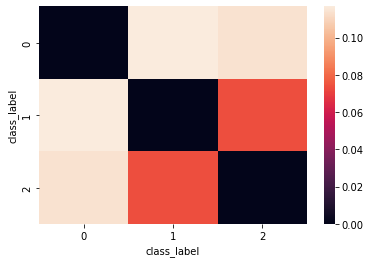

In [15]:

sns.heatmap(pd.DataFrame(distances, mean_attributes_df.index, mean_attributes_df.index), )

## Distribution of distances from class centroids (variance within class)

In [16]:
mean_attributes = np.array([mean_attributes_df.loc[cn] for cn in class_names]) # Has the same order as class names

<AxesSubplot:xlabel='difference', ylabel='label'>

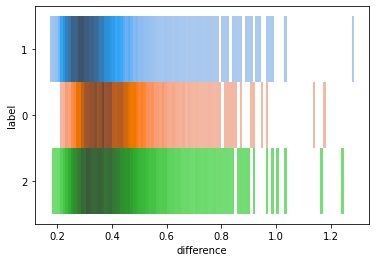

In [17]:

df_attribute_differences = pd.DataFrame({'difference' : np.linalg.norm(graph.attr_matrix.toarray() - mean_attributes[graph.labels], axis=-1), 'label' : class_names[graph.labels]},)
sns.histplot(df_attribute_differences, x='difference', y='label', hue='label', legend=False,
                     common_norm=False,)

## Average pairwise feature distances within community pairs

In [18]:
from sklearn.metrics import pairwise_distances
attr_mat = graph.attr_matrix.toarray()
pairwise_distances = pairwise_distances(graph.attr_matrix, graph.attr_matrix, n_jobs=-1)

In [19]:
avg_distances_per_class = np.zeros((len(np.unique(graph.labels)), len(np.unique(graph.labels))))
for label_i in range(len(np.unique(graph.labels))):
    for label_j in range(len(np.unique(graph.labels))):
        avg_distances_per_class[label_i, label_j] = pairwise_distances[graph.labels == label_i][:, graph.labels == label_j].mean()

<AxesSubplot:>

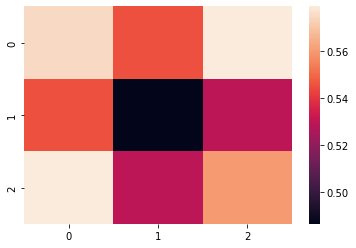

In [20]:
sns.heatmap(pd.DataFrame(avg_distances_per_class, class_names, class_names))

## Plot of attributes with high values per class

In [21]:
mean_attributes_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
class_label,,,,,,,,,,,,,,,,,,,,,
0,0.067827,0.001321,0.005390,0.005574,0.002938,0.002440,0.005050,0.005440,0.021504,0.006975,...,0.009735,0.002837,0.003489,0.000403,0.000212,0.000205,0.001143,0.004188,0.004088,0.000778
1,0.004011,0.004171,0.007176,0.004531,0.002097,0.004578,0.001026,0.006655,0.001549,0.004928,...,0.001179,0.002203,0.002551,0.002602,0.000246,0.001907,0.000097,0.003061,0.001497,0.006924
2,0.004485,0.003095,0.006806,0.003789,0.003359,0.006521,0.004981,0.006050,0.002962,0.005316,...,0.002234,0.002894,0.000826,0.002255,0.005506,0.004024,0.007451,0.002581,0.003266,0.003420


### Distribution of mean values of all features and classes (to determine thresholds for "frequent attributes")

<AxesSubplot:ylabel='Count'>

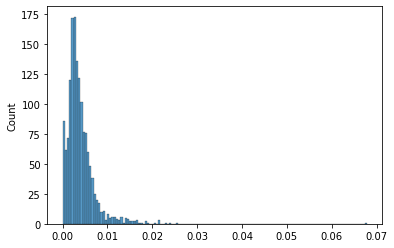

In [22]:
sns.histplot(mean_attributes_df.to_numpy().flatten())

In [23]:
threshold = 0.2 # Attributes with a mean per class that is higher than that are considered "frequent"
columns_above_threshold = [c for c in mean_attributes_df.columns if (mean_attributes_df[c] >= threshold).any()]
plt.figure(figsize=(15, 5))
sns.heatmap(mean_attributes_df[columns_above_threshold])

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1080x360 with 0 Axes>